In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics 
from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import ast
import random

In [43]:
tedtalks = pd.read_csv('data/TED_Talks_final.csv')
print('Original dataset')
print('Data points:', tedtalks.shape[0])
print('Average number of words in each doc:',tedtalks['transcript'].apply(lambda x:len(x)).sum()/tedtalks.shape[0])
vect = CountVectorizer(stop_words = 'english' ,lowercase = True)
vect.fit(tedtalks['transcript'])
print('Vocab size:',len(vect.get_feature_names()))

Original dataset
Data points: 4089
Average number of words in each doc: 9966.836634874053
Vocab size: 69596


Selecting only some topics to even out the distribution

In [44]:
tag_list = []
tedtalks['talks__tags'].apply(lambda x:tag_list.extend(ast.literal_eval(x)))
tag_list = [tag.lower() for tag in tag_list if 'TED' not in tag]
counts = Counter(tag_list)
print('Number of times a tag appears in the dataset (top 100):')
print(counts.most_common(100))

Number of times a tag appears in the dataset (top 100):
[('science', 1005), ('technology', 990), ('culture', 690), ('global issues', 580), ('society', 564), ('social change', 527), ('design', 524), ('animation', 516), ('health', 457), ('business', 447), ('education', 423), ('history', 420), ('humanity', 396), ('innovation', 373), ('biology', 363), ('entertainment', 348), ('art', 332), ('future', 332), ('communication', 326), ('creativity', 316), ('community', 306), ('activism', 286), ('medicine', 273), ('brain', 261), ('collaboration', 251), ('personal growth', 243), ('economics', 239), ('environment', 237), ('health care', 236), ('nature', 231), ('psychology', 221), ('invention', 221), ('politics', 210), ('identity', 207), ('animals', 205), ('children', 203), ('women', 193), ('life', 188), ('medical research', 178), ('climate change', 177), ('computers', 171), ('human body', 170), ('music', 167), ('storytelling', 167), ('africa', 165), ('inequality', 163), ('public health', 160), ('wa

Selecting some of the tags that have in between 50 and 100 transcripts tagged with them and that are distinct enough to not overlap too much

In [12]:
selected_tags = ['race', 'universe', 'environment', 'food', 'religion', 'architecture', 'software','poverty']
boolval = tedtalks['talks__tags'].apply(lambda x:len(set(ast.literal_eval(x)).intersection(selected_tags))) != 0 
tedtalks = tedtalks[boolval]

Selecting documents that have these tags on their list of tags

In [18]:
#shuffling data and adding some commonly found words to the stop word list
tedtalks = tedtalks.sample(frac = 1) 
tedtalks.reset_index(inplace=True, drop=True)
newstopwords = ['music', 'applause', 'thank', 'yeah', 'voice', 'like', 'know', 'just', 'people', 'laughter', 'one', 'us', 'going', 'would', 'make', 'actually', 'said','say', 'really', 'get', 'see', 'something', 'could', 'also', 'many', 'right', 'way', 'need', 'things','go', 'want', 'well', 'thing', 'little', 'got', 'lot', 'went']
nltkstopwords = stopwords.words('english')
nltkstopwords.extend(newstopwords)

print('Trimmed down dataset')
print('Data points:', tedtalks.shape[0])
print('Average number of words in each doc:',tedtalks['transcript'].apply(lambda x:len(x)).sum()/tedtalks.shape[0])
vect = CountVectorizer(stop_words = nltkstopwords ,lowercase = True)
vect.fit(tedtalks['transcript'])
print('Vocab size:',len(vect.get_feature_names()))

Trimmed down dataset
Data points: 828
Average number of words in each doc: 10433.876811594202
Vocab size: 35523


Using the elbow method to choose (confirm) the optimal number of clusters. I selected 8 different topic tags so we'll see if 8 clusters is actually the optimal number or if the documents are too different, I will test with 20 clusters max

Text(0.5, 0, '# clusters')

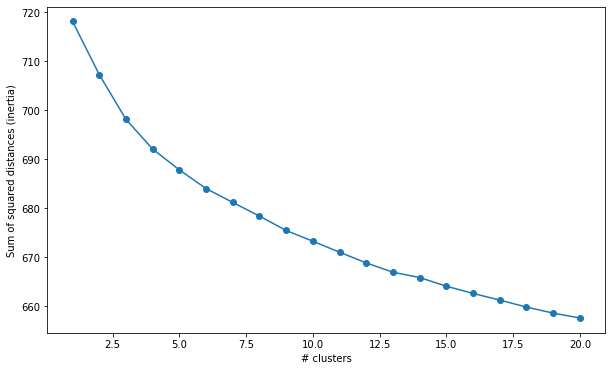

In [19]:
centroid_seed = 15
vect = CountVectorizer(stop_words = nltkstopwords ,lowercase = True, max_features=2000, max_df=500)
counter = vect.fit_transform(tedtalks['transcript'])

inertia = []
k_vals = list(range(1,21))
transf  = TfidfTransformer(norm = 'l2', sublinear_tf = True) 
tf_idf = transf.fit_transform(counter)

for k in k_vals:
    model = KMeans(n_clusters=k, init='k-means++', max_iter=100, random_state=centroid_seed, n_init=10, verbose = 0)
    model.fit(tf_idf)
    inertia.append(model.inertia_)

plt.figure(figsize=(10,6))
plt.plot(k_vals, inertia, '-o')
plt.ylabel('Sum of squared distances (inertia)')
plt.xlabel('# clusters')

The graph is not too clear but it seems like the optimal number of documents is in between 5 and 10 so I'll just use 8 to train

<h3>K-Means model with tf-idf vectors:

In [20]:
num_topics = 8

model = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, random_state=centroid_seed, n_init=10, verbose = 0)
model.fit(tf_idf)
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vect.get_feature_names()
print('Top 5 terms per cluster:')
for i in range(num_topics):
    print('Cluster', i),
    for ind in order_centroids[i, :5]:
        print(terms[ind])

Top 5 terms per cluster:
Cluster 0
architecture
building
city
design
buildings
Cluster 1
children
poverty
kids
percent
school
Cluster 2
climate
carbon
global
energy
change
Cluster 3
universe
stars
galaxy
planets
space
Cluster 4
earth
water
different
planet
let
Cluster 5
black
white
women
woman
men
Cluster 6
food
eat
plant
plants
foods
Cluster 7
religious
god
religion
faith
compassion


In [27]:
tf_idf_score = metrics.silhouette_score(tf_idf, model.labels_, metric = "cosine")
print('Silhouette score for KMeans with TF-IDF:', tf_idf_score)

Silhouette score for KMeans with TF-IDF: 0.024290456931435753


<h3>Now I will test K-Means with vectors as LDA topic distributions, will use 8 topics

In [21]:
def display_topics(components, feature_names):
    for topic_num, topic in enumerate(components):
        print(f'Topic {topic_num}:')
        words = []
        for i in topic.argsort()[:-10 - 1:-1]:
            words.append(feature_names[i])
        print(words)

<h3> LDA Model

In [22]:
lda_model = LatentDirichletAllocation(n_components = num_topics, max_iter= 10, learning_method = 'online', random_state=10)
lda_doc_topics = lda_model.fit_transform(counter)
feature_names = vect.get_feature_names()
display_topics(lda_model.components_, feature_names)

Topic 0:
['food', 'fish', 'species', 'eat', 'animals', 'plants', 'plant', 'different', 'bees', 'feed']
Topic 1:
['climate', 'change', 'percent', 'global', 'energy', 'oil', 'billion', 'countries', 'dollars', 'problem']
Topic 2:
['earth', 'universe', 'space', 'planet', 'light', 'planets', 'stars', 'energy', 'sun', 'different']
Topic 3:
['black', 'women', 'white', 'health', 'police', 'men', 'country', 'violence', 'race', 'community']
Topic 4:
['building', 'city', 'kind', 'design', 'architecture', 'space', 'idea', 'create', 'built', 'different']
Topic 5:
['children', 'school', 'god', 'kids', 'family', 'never', 'believe', 'human', 'religion', 'old']
Topic 6:
['water', 'air', 'ocean', 'city', 'use', 'river', 'land', 'high', 'sea', '000']
Topic 7:
['kind', 'started', 'feel', 'tell', 'let', 'great', 'person', 'human', 'man', 'always']


sample of topic distribution per doc

In [25]:
lda_doc_topics[:5]

array([[1.76610056e-04, 6.06417388e-02, 7.65366881e-01, 1.76569122e-04,
        1.76587360e-04, 1.25569070e-01, 4.77159085e-02, 1.76635105e-04],
       [2.76969237e-04, 8.32940851e-02, 2.76974663e-04, 2.82018417e-01,
        3.43552689e-01, 2.77033388e-04, 2.90026794e-01, 2.77037350e-04],
       [3.16211216e-04, 5.09815991e-01, 3.16302445e-04, 8.35029291e-02,
        3.16116464e-04, 3.16261129e-04, 4.05100049e-01, 3.16139843e-04],
       [1.89660725e-01, 2.94316379e-01, 8.07898480e-04, 8.07485933e-04,
        2.22065509e-01, 8.07929000e-04, 8.07541756e-04, 2.90726532e-01],
       [2.42611260e-04, 2.42815703e-04, 9.98301022e-01, 2.42694331e-04,
        2.42683171e-04, 2.42728655e-04, 2.42689668e-04, 2.42754743e-04]])

<h3> KMeans clustering with topic distributions as vectors

In [28]:
model_kmeans_lda = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, random_state=centroid_seed, n_init=10, verbose = 0)
model_kmeans_lda.fit(lda_doc_topics)
lda_sill_score = metrics.silhouette_score(lda_doc_topics,model_kmeans_lda.labels_, metric = "cosine")
print('Silhouette score for KMeans with LDA topic distribution:', lda_sill_score)

Silhouette score for KMeans with LDA topic distribution: 0.6192424544213476


Topics per cluster:

LDA

In [45]:
labels_lda = pd.DataFrame(model_kmeans_lda.labels_)
labels_lda.value_counts().sort_index()

0     95
1    111
2    140
3    111
4     57
5     99
6     99
7    116
dtype: int64

TF-IDF

In [46]:
labels_tfidf = pd.DataFrame(model.labels_)
labels_tfidf.value_counts().sort_index()

0     83
1    133
2     99
3     82
4    157
5    121
6     87
7     66
dtype: int64